In [92]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy import stats

#Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
plt.style.use('seaborn')

from sklearn.cluster import KMeans


from category_encoders import CatBoostEncoder
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# импортируем tensorflow и keras

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [93]:
test = pd.read_csv('/Users/andrei/repos/HousePricing/Data/test.csv')
train = pd.read_csv('/Users/andrei/repos/HousePricing/Data/train.csv')

In [94]:
train['SalePrice'] = np.log1p(train['SalePrice'])
target = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

fdf = pd.concat([train_features, test_features]).reset_index(drop=True)
print(fdf.shape)

(2919, 80)


In [95]:
nonelist = ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType')

zerolist = ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtHalfBath', 'BsmtFullBath', 'MasVnrArea')

for col in nonelist:
    fdf[col].fillna('None', inplace=True)
    
for col in zerolist:
    fdf[col].fillna(0, inplace=True)
    
fdf["LotFrontage"] = fdf.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

fdf['MSZoning'].fillna('RL', inplace=True)
fdf['Functional'].fillna('Typ', inplace=True)
fdf['Electrical'].fillna('SBrkr', inplace=True)
fdf['KitchenQual'].fillna('TA', inplace=True)
fdf['Exterior1st'].fillna('TA', inplace=True)
fdf['Exterior2nd'].fillna('TA', inplace=True)
fdf['SaleType'].fillna('WD', inplace=True)
fdf['Utilities'].fillna('AllPub', inplace=True)

In [96]:
cfdf = pd.concat([fdf[:1460], target], axis = 1)
corrmat = cfdf.corr()
corfeat = corrmat['SalePrice'][abs(corrmat['SalePrice']) >= 0.6].sort_values(ascending=False)
clist = corfeat.index.tolist()
clist.remove('SalePrice')
cldf = pd.DataFrame(fdf[clist])
scaler = StandardScaler()
scaledX = scaler.fit_transform(cldf)
cluster = KMeans(3, random_state=10)
cluster_labels = cluster.fit_predict(scaledX)
fdf['Cluster'] = cluster_labels

In [97]:
clabels = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope' \
,'Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl' \
,'Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual' \
,'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir' \
,'Electrical','KitchenQual','Functional','FireplaceQu','GarageType','GarageFinish','GarageQual' \
,'GarageCond','PavedDrive','PoolQC','Fence','MiscFeature','SaleType','SaleCondition', 'Cluster']

In [ ]:
for j in range(1,2):
    
    if j == 1:
        cat_encoder = CatBoostEncoder(cols=clabels)
        encoded_df = cat_encoder.fit_transform(fdf[:1460], target)
        test_encoded = cat_encoder.transform(fdf[1460:])
        scaler = StandardScaler()
        scaledX = scaler.fit_transform(encoded_df)
        scaledtest = scaler.transform(test_encoded)

        xtrain, xvalid, ytrain, yvalid = train_test_split(scaledX, target, test_size = 0.25)
        
        inp = keras.layers.Input((xtrain.shape[1]))
        # x = keras.layers.Flatten()(inp)
        x = keras.layers.Dense(128, activation='relu', name = 'fc1')(inp)
        x = keras.layers.Dense(64, activation='relu', name = 'fc2')(x)
        x = keras.layers.Dropout(0.5)(x)
        output = keras.layers.Dense(1, activation='linear')(x)

        model = keras.Model(inp, output)
        
        model.compile(
        loss='mean_squared_logarithmic_error',
        metrics=tf.keras.metrics.mean_absolute_error,
        optimizer=keras.optimizers.Adam(lr=0.001)
        )

        history = HistoryCallback()
        
        model.fit(
        xtrain,
        ytrain,
        batch_size=200,
        validation_data=(xvalid, yvalid),
        callbacks=[history],
        epochs=10,
        verbose=1
        );
        
        testresult = np.expm1(kmodel.predict(scaledtest))
        t = pd.concat([test, pd.DataFrame(testresult)], axis=1)
        t.rename(columns={0:'SalePrice'}, inplace=True)
        t[['Id', 'SalePrice']].to_csv('predictions2.csv', sep=',', index=False)

    else:
        answer = pd.read_csv(f'predictions{j}.csv')
        target = pd.DataFrame(data=pd.concat([np.expm1(train['SalePrice']), answer['SalePrice']],axis=0))
        alldf['SalePrice'] = np.log1p(alldf['SalePrice'])
        cat_encoder = CatBoostEncoder(cols=clabels)
        encoded_df = cat_encoder.fit_transform(fdf.drop('Id', axis=1), alldf.reset_index(drop=True))
        scaler = StandardScaler()
        scaledX = scaler.fit_transform(encoded_df)

        xtrain, xvalid, ytrain, yvalid = train_test_split(scaledX, 
                                                            alldf['SalePrice'], 
                                                            random_state=666, 
                                                            train_size=0.7)

        inp = keras.layers.Input((xtrain.shape[1]))
        x = keras.layers.Dense(512, activation=tf.keras.activations.gelu, name = 'fc1')(inp)
        x = keras.layers.Dropout(0.5)(x)
        output = keras.layers.Dense(1, activation=tf.keras.activations.linear)(x)

        kmodel = keras.Model(inp, output)

        kmodel.summary()

        history = HistoryCallback()

        kmodel.compile(
        loss='mean_squared_logarithmic_error',
        metrics=tf.keras.metrics.mean_absolute_error,
        optimizer=keras.optimizers.Adam(lr=0.001)
        )

        kmodel.fit(
            xtrain,
            ytrain,
            batch_size=32,
            validation_data=(xvalid, yvalid),
            callbacks=[history],
            epochs=100,
            verbose=1
            );

        prediction = np.expm1(kmodel.predict(scaledX[1460:]))
        t = pd.concat([test, pd.DataFrame(prediction)], axis=1)
        t.rename(columns={0:'SalePrice'}, inplace=True)
        t[['Id', 'SalePrice']].to_csv(f'final_result{j+1}.csv', sep=',', index=False)

In [98]:
# callback - это набор функций, которые автоматически вызываются в разные моменты обучения модели
# и выполняют любые необходимые действия
# https://keras.io/api/callbacks/
# https://keras.io/guides/writing_your_own_callbacks/

# этот callback запоминает значение loss и accuracy после каждой эпохи, и выводит график в конце 
class HistoryCallback(keras.callbacks.Callback):
    def __init__(self):
        self.epochs = 0
        self.train_loss = []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []
        
        %matplotlib inline
    
    # функция будет вызываться в конце каждой эпохи обучения
    def on_epoch_end(self, epoch, logs=None):
        self.epochs += 1
        self.train_loss.append(logs['loss'])
        self.train_acc.append(logs['mean_absolute_error'])
        self.val_loss.append(logs['val_loss'])
        self.val_acc.append(logs['val_mean_absolute_error'])
        
        
    # функция будет вызываться в самом конце обучения    
    def on_train_end(self, epoch, logs=None):
        self.plot()
        
    def plot(self):
        fig, ax = plt.subplots(1,2, figsize=(10,5))
        
        ax[0].plot(self.train_loss, label='train loss')
        ax[0].plot(self.val_loss, label='val loss')
        ax[0].legend()
        ax[1].plot(self.train_acc, label='train mean_absolute_error')
        ax[1].plot(self.val_acc, label='val mean_absolute_error')
        ax[1].legend()
        plt.show()

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice, Length: 1460, dtype: float64

/Users/andrei/opt/anaconda3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
6/6 [==============================] - 0s 30ms/step - loss: 123.2946 - mean_absolute_error: 180036.2500 - val_loss: 102.6734 - val_mean_absolute_error: 183564.0781
Epoch 2/10
6/6 [==============================] - 0s 9ms/step - loss: 97.0038 - mean_absolute_error: 180029.9219 - val_loss: 88.7249 - val_mean_absolute_error: 183556.7969
Epoch 3/10
6/6 [==============================] - 0s 9ms/step - loss: 85.3514 - mean_absolute_error: 180022.2031 - val_loss: 79.9186 - val_mean_absolute_error: 183548.0156
Epoch 4/10
6/6 [==============================] - 0s 9ms/step - loss: 77.5198 - mean_absolute_error: 180013.0469 - val_loss: 73.4405 - val_mean_absolute_error: 183537.6250
Epoch 5/10
6/6 [==============================] - 0s 14ms/step - loss: 71.6113 - mean_absolute_error: 180002.3281 - val_loss: 68.3077 - val_mean_absolute_error: 183525.5312
Epoch 6/10
6/6 [==============================] - 0s 10ms/step - loss: 66.7854 - mean_absolute_error: 179989.7031 - val_loss: 64.0659 - 

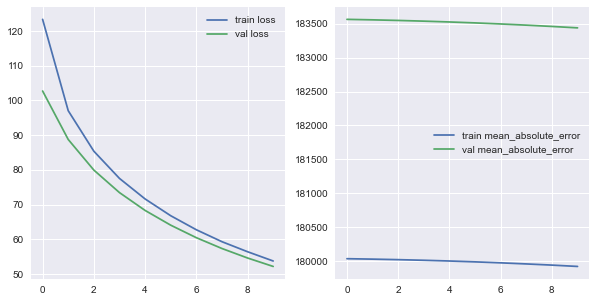

In [118]:
cat_encoder = CatBoostEncoder(cols=clabels)
encoded_df = cat_encoder.fit_transform(fdf[:1460], np.expm1(target))
test_encoded = cat_encoder.transform(fdf[1460:])
scaler = StandardScaler()
scaledX = scaler.fit_transform(encoded_df)
scaledtest = scaler.transform(test_encoded)
xtrain, xvalid, ytrain, yvalid = train_test_split(scaledX, np.expm1(target), test_size = 0.25)

inp = keras.layers.Input((xtrain.shape[1]))
# x = keras.layers.Flatten()(inp)
x = keras.layers.Dense(512, activation='relu', name = 'fc1')(inp)
x = keras.layers.Dense(256, activation='relu', name = 'fc2')(x)
x = keras.layers.Dropout(0.3)(x)
output = keras.layers.Dense(1, activation='linear')(x)
model = keras.Model(inp, output)

model.compile(
loss='mean_squared_logarithmic_error',
metrics=tf.keras.metrics.mean_absolute_error,
optimizer=keras.optimizers.Adam(lr=0.001)
)
history = HistoryCallback()

model.fit(
xtrain,
ytrain,
batch_size=200,
validation_data=(xvalid, yvalid),
callbacks=[history],
epochs=10,
verbose=1
);

testresult = model.predict(scaledtest)
#t = pd.concat([test, pd.DataFrame(testresult)], axis=1)
#t.rename(columns={0:'SalePrice'}, inplace=True)
#t[['Id', 'SalePrice']].to_csv('predictions2.csv', sep=',', index=False)

In [120]:
testresult

array([[126.97076 ],
       [114.433136],
       [ 91.52563 ],
       ...,
       [ 91.90158 ],
       [144.72343 ],
       [120.58158 ]], dtype=float32)

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 80)]              0         
                                                                 
 fc1 (Dense)                 (None, 512)               41472     
                                                                 
 dropout_24 (Dropout)        (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 1)                 513       
                                                                 
Total params: 41,985
Trainable params: 41,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/Users/andrei/opt/anaconda3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


64/64 [==============================] - 1s 5ms/step - loss: 118.9296 - mean_absolute_error: 178587.2344 - val_loss: 99.5036 - val_mean_absolute_error: 182282.8125
Epoch 2/100
64/64 [==============================] - 0s 2ms/step - loss: 88.6236 - mean_absolute_error: 178575.4844 - val_loss: 80.1649 - val_mean_absolute_error: 182267.2656
Epoch 3/100
64/64 [==============================] - 0s 2ms/step - loss: 75.1268 - mean_absolute_error: 178558.5000 - val_loss: 70.3972 - val_mean_absolute_error: 182248.4375
Epoch 4/100
64/64 [==============================] - 0s 2ms/step - loss: 67.1969 - mean_absolute_error: 178538.8906 - val_loss: 63.8816 - val_mean_absolute_error: 182227.0312
Epoch 5/100
64/64 [==============================] - 0s 2ms/step - loss: 61.5441 - mean_absolute_error: 178516.7188 - val_loss: 59.0521 - val_mean_absolute_error: 182203.4688
Epoch 6/100
64/64 [==============================] - 0s 2ms/step - loss: 57.3036 - mean_absolute_error: 178492.9219 - val_loss: 55.2532 

Epoch 48/100
64/64 [==============================] - 0s 2ms/step - loss: 19.2764 - mean_absolute_error: 176194.4062 - val_loss: 19.0291 - val_mean_absolute_error: 179800.8594
Epoch 49/100
64/64 [==============================] - 0s 2ms/step - loss: 18.9795 - mean_absolute_error: 176105.3125 - val_loss: 18.7176 - val_mean_absolute_error: 179709.5938
Epoch 50/100
64/64 [==============================] - 0s 2ms/step - loss: 18.6658 - mean_absolute_error: 176016.2656 - val_loss: 18.4137 - val_mean_absolute_error: 179616.2031
Epoch 51/100
64/64 [==============================] - 0s 2ms/step - loss: 18.3836 - mean_absolute_error: 175932.7656 - val_loss: 18.1170 - val_mean_absolute_error: 179521.0469
Epoch 52/100
64/64 [==============================] - 0s 2ms/step - loss: 18.0860 - mean_absolute_error: 175838.0781 - val_loss: 17.8267 - val_mean_absolute_error: 179423.7812
Epoch 53/100
64/64 [==============================] - 0s 2ms/step - loss: 17.7766 - mean_absolute_error: 175736.3125 - v

64/64 [==============================] - 0s 2ms/step - loss: 9.5203 - mean_absolute_error: 169660.5938 - val_loss: 9.3580 - val_mean_absolute_error: 173019.8281
Epoch 95/100
64/64 [==============================] - 0s 2ms/step - loss: 9.3566 - mean_absolute_error: 169407.6094 - val_loss: 9.2163 - val_mean_absolute_error: 172798.6250
Epoch 96/100
64/64 [==============================] - 0s 2ms/step - loss: 9.2044 - mean_absolute_error: 169181.8281 - val_loss: 9.0767 - val_mean_absolute_error: 172573.5156
Epoch 97/100
64/64 [==============================] - 0s 2ms/step - loss: 9.0857 - mean_absolute_error: 168982.7969 - val_loss: 8.9388 - val_mean_absolute_error: 172345.1250
Epoch 98/100
64/64 [==============================] - 0s 2ms/step - loss: 8.9460 - mean_absolute_error: 168750.9844 - val_loss: 8.8031 - val_mean_absolute_error: 172112.7812
Epoch 99/100
64/64 [==============================] - 0s 2ms/step - loss: 8.8064 - mean_absolute_error: 168500.6250 - val_loss: 8.6689 - val_me

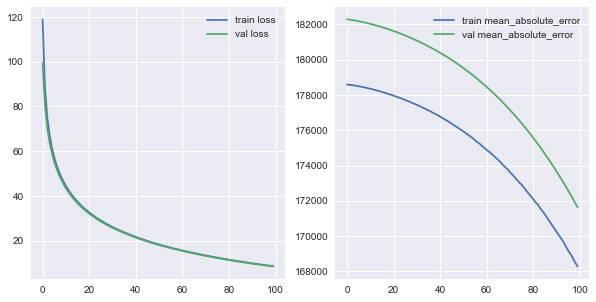

/var/folders/zy/htfch__97qz4dyhw078s95940000gn/T/ipykernel_24839/390015491.py:41: RuntimeWarning: overflow encountered in expm1
  prediction = np.expm1(kmodel.predict(scaledX[1460:]))


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,inf
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,inf
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,inf
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,inf
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,inf
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,inf
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,inf
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,inf


In [80]:
answer = pd.read_csv(f'final_result{j}.csv')
target = pd.DataFrame(data=pd.concat([np.expm1(train['SalePrice']), answer['SalePrice']],axis=0))
#alldf['SalePrice'] = np.log1p(alldf['SalePrice'])
cat_encoder = CatBoostEncoder(cols=clabels)
encoded_df = cat_encoder.fit_transform(fdf.drop('Id', axis=1), alldf.reset_index(drop=True))
scaler = StandardScaler()
scaledX = scaler.fit_transform(encoded_df)

xtrain, xvalid, ytrain, yvalid = train_test_split(scaledX, 
                                                        target, 
                                                        random_state=666, 
                                                        train_size=0.7)
    
inp = keras.layers.Input((xtrain.shape[1]))
x = keras.layers.Dense(512, activation=tf.keras.activations.gelu, name = 'fc1')(inp)
x = keras.layers.Dropout(0.5)(x)
output = keras.layers.Dense(1, activation=tf.keras.activations.linear)(x)

kmodel = keras.Model(inp, output)

kmodel.summary()

history = HistoryCallback()

kmodel.compile(
    loss='mean_squared_logarithmic_error',
    metrics=tf.keras.metrics.mean_absolute_error,
    optimizer=keras.optimizers.Adam(lr=0.001)
    )

kmodel.fit(
        xtrain,
        ytrain,
        batch_size=32,
        validation_data=(xvalid, yvalid),
        callbacks=[history],
        epochs=100,
        verbose=1
        );
    
prediction = np.expm1(kmodel.predict(scaledX[1460:]))
t = pd.concat([test, pd.DataFrame(prediction)], axis=1)
t.rename(columns={0:'SalePrice'}, inplace=True)
t
#t[['Id', 'SalePrice']].to_csv(f'final_result{j+1}.csv', sep=',', index=False)

In [78]:
prediction = kmodel.predict(scaledX[1460:])
prediction

array([[0.139633  ],
       [0.041598  ],
       [0.11779722],
       ...,
       [0.11353204],
       [0.12533076],
       [0.10630128]], dtype=float32)